# Leios simulation analysis at tag `leios-2025w29`

## Load packages

In [1]:
suppressMessages({
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(magrittr, quietly=TRUE)
})

## Experiment: Linear Leios

In [6]:
label <- "Rust simulator, mini-mainnet, 100 tx/s, 1400 B/tx"

### Analysis of lifecycles and efficiencies

#### Read the lifecycle results

In [7]:
if (file.exists("results/lifecycle.Rdata")) {
    load(file="results/lifecycle.Rdata")
    cat(paste("Loaded Rdata file: sampleSize =", sampleSize, "\n"))
} else {
    lifecycle <- fread("results/lifecycle.csv.gz", stringsAsFactors=TRUE)
    sampleSize <- 1
#   save(lifecycle, sampleSize, file="results/lifecycle.R")
}
lifecycle[, `:=`(`Max EB size`=factor(`Max EB size`, levels=c("50.0 MB/EB", "20.0 MB/EB", "10.0 MB/EB", "5.0 MB/EB", "2.0 MB/EB", "1.0 MB/EB", "0.5 MB/EB", "0.2 MB/EB")), `Stage length`=factor(`Stage length`, levels=c("5 slot/stage", "8 slot/stage", "15 slot/stage")))]
lifecycle %>% summary

 Simulator                          Variant              Stage length   
 Rust:359034   linear                   :179594   5 slot/stage :179518  
               linear-with-tx-references:179440   8 slot/stage :179516  
                                                  15 slot/stage:     0  
                                                                        
                                                                        
                                                                        
                                                                        
     Max EB size     Kind                 Item           Size [B]       
 5.0 MB/EB :119730   EB:   169   20-node-220:    24   Min.   :    1400  
 20.0 MB/EB:119652   RB:   169   26-node-95 :    24   1st Qu.:    1400  
 10.0 MB/EB:119652   TX:358696   54-node-525:    24   Median :    1400  
 50.0 MB/EB:     0               95-node-178:    18   Mean   :    2545  
 2.0 MB/EB :     0               0          :    12

#### Range of transaction injection

In [8]:
txFirst <- 0
txLast <- 300
txWindow <- txLast - txFirst
simFinish <- 300

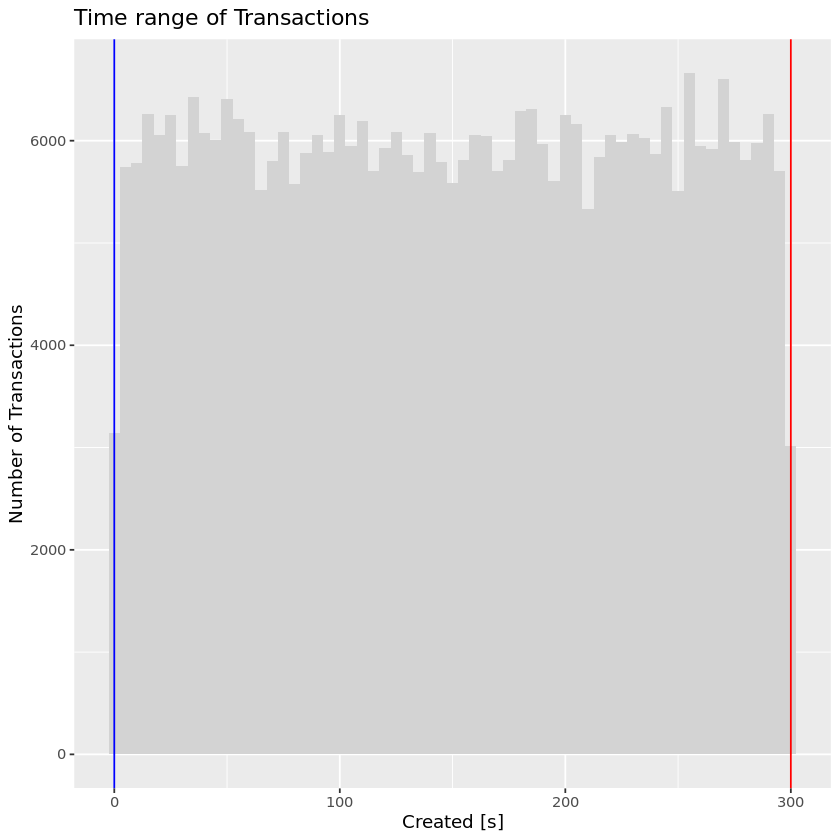

In [9]:
ggplot(lifecycle, aes(x=`Created [s]`)) +
    geom_histogram(binwidth=5, fill="lightgray") +
    geom_vline(xintercept=txFirst, color="blue") +
    geom_vline(xintercept=txLast, color="red") +
    ylab("Number of Transactions") +
    ggtitle("Time range of Transactions")

#### Actual TPS

In [10]:
lifecycle[
    `Kind` == "TX" & `Created [s]` >= txFirst & `Created [s]` <= txLast, 
    .(
        `Demand [tx/s]`=.N/txWindow,
        `Demand [MB/s]`=sum(`Size [B]`)/1e6/txWindow,
        `Demand [Mb/s]`=8*sum(`Size [B]`)/1e6/txWindow,
        `Time to full EB [s]`=1/(sum(`Size [B]`)/(1e6*as.numeric(substring(`Max EB size`, 1, 4)))/txWindow),
        `Transaction size [B/tx]`=sum(`Size [B]`)/.N
    ),
    .(`Variant`, `Stage length`, `Max EB size`)
][order(`Variant`, `Stage length`, - `Max EB size`)]

Variant,Stage length,Max EB size,Demand [tx/s],Demand [MB/s],Demand [Mb/s],Time to full EB [s],Transaction size [B/tx]
<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
linear,5 slot/stage,5.0 MB/EB,99.67333,0.1395427,1.116341,35.83133,1400
linear,5 slot/stage,10.0 MB/EB,99.67333,0.1395427,1.116341,71.66267,1400
linear,5 slot/stage,20.0 MB/EB,99.67333,0.1395427,1.116341,143.32534,1400
linear,8 slot/stage,5.0 MB/EB,99.67333,0.1395427,1.116341,35.83133,1400
linear,8 slot/stage,10.0 MB/EB,99.67333,0.1395427,1.116341,71.66267,1400
linear,8 slot/stage,20.0 MB/EB,99.67333,0.1395427,1.116341,143.32534,1400
linear-with-tx-references,5 slot/stage,5.0 MB/EB,99.67333,0.1395427,1.116341,35.83133,1400
linear-with-tx-references,5 slot/stage,10.0 MB/EB,99.56667,0.1393933,1.115147,71.73944,1400
linear-with-tx-references,5 slot/stage,20.0 MB/EB,99.56667,0.1393933,1.115147,143.47888,1400


#### Size of persisted data

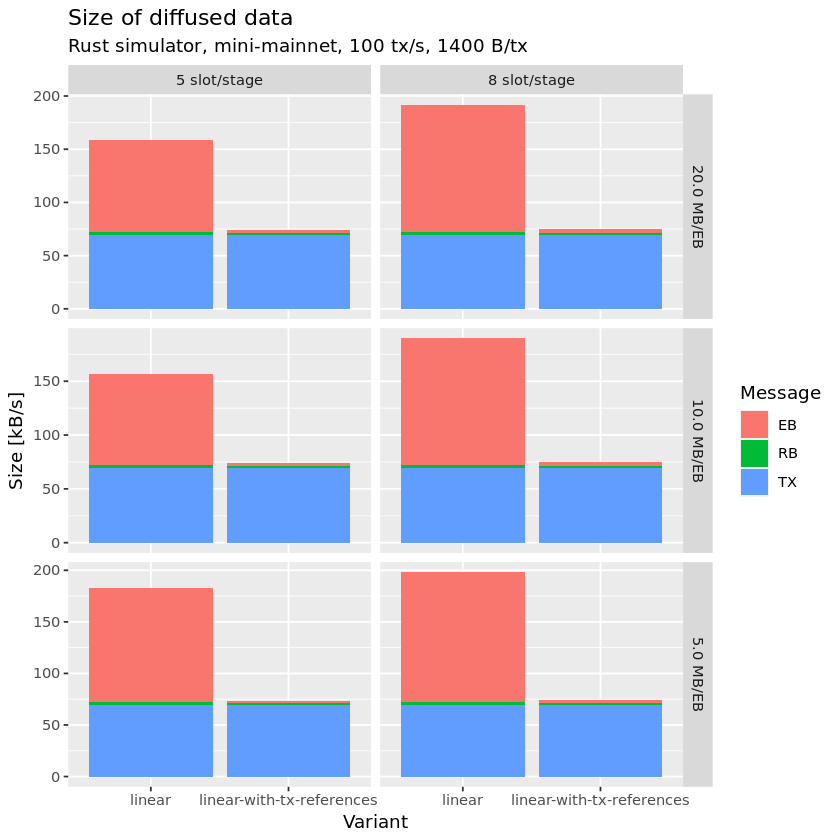

In [11]:
ggplot(
    lifecycle[,
        .(`Size [kB/s]`=sum(`Size [B]`)/1e3/600),
        .(`Variant`, `Message`=`Kind`, `Stage length`, `Max EB size`)
    ],
    aes(x=`Variant`, y=`Size [kB/s]`, fill=`Message`)
) + geom_bar(stat="identity") +
    facet_grid(`Max EB size` ~ `Stage length`, scales="free_y") +
    ggtitle("Size of diffused data", subtitle=label)

In [12]:
ggsave("plots/sizes.png", units="in", dpi=150, width=8, height=6)

In [13]:
ggsave("plots/sizes.svg", units="in", dpi=150, width=8, height=6)

#### Spatial efficiency

In [14]:
lifecycle[
        `Kind` == "TX", 
        .(`Tx size [B]`=sum(ifelse(is.na(`To RB [s]`) & is.na(`In RB [s]`), 0, 1.0 * `Size [B]`))),
        .(`Variant`, `Stage length`, `Max EB size`)
    ][
        lifecycle[
            , 
            .(`Non-tx size [B]`=sum(as.numeric((`Variant` == "linear-with-tx-references" & `Kind` == "TX" | `Kind` == "EB" | `Kind` == "RB") * `Size [B]`))), 
            .(`Variant`, `Stage length`, `Max EB size`)
        ],
        on=c("Variant", "Stage length", "Max EB size")
    ][, .(`Variant`, `Stage length`, `Max EB size`, `Space efficiency [%]`=100*`Tx size [B]`/`Non-tx size [B]`)][order(`Variant`, `Stage length`, -`Max EB size`)]

Variant,Stage length,Max EB size,Space efficiency [%]
<fct>,<fct>,<fct>,<dbl>
linear,5 slot/stage,5.0 MB/EB,41.78164
linear,5 slot/stage,10.0 MB/EB,43.80691
linear,5 slot/stage,20.0 MB/EB,42.72492
linear,8 slot/stage,5.0 MB/EB,31.47694
linear,8 slot/stage,10.0 MB/EB,31.75866
linear,8 slot/stage,20.0 MB/EB,31.20319
linear-with-tx-references,5 slot/stage,5.0 MB/EB,65.02432
linear-with-tx-references,5 slot/stage,10.0 MB/EB,69.04843
linear-with-tx-references,5 slot/stage,20.0 MB/EB,69.02358


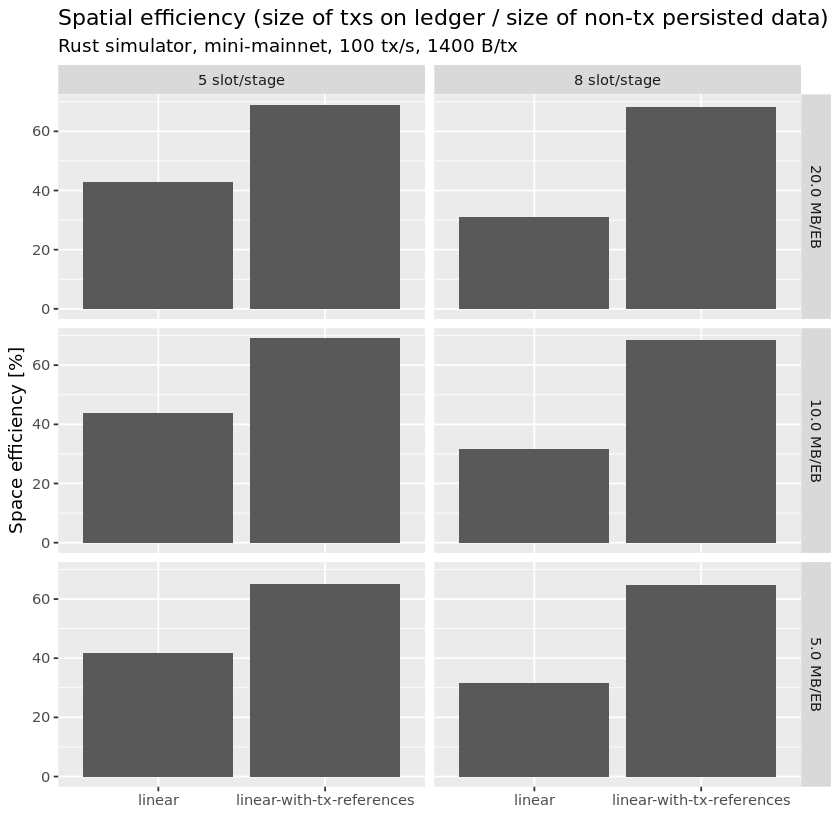

In [15]:
ggplot(
    lifecycle[
        `Kind` == "TX", 
        .(`Tx size [B]`=sum(ifelse(is.na(`To RB [s]`) & is.na(`In RB [s]`), 0, 1.0 * `Size [B]`))),
        .(`Variant`, `Stage length`, `Max EB size`)
    ][
        lifecycle[
            `Kind` != "VT", 
            .(`Non-tx size [B]`=sum(as.numeric((`Variant` == "linear-with-tx-references" & `Kind` == "TX" | `Kind` == "EB" | `Kind` == "RB") * `Size [B]`))), 
            .(`Variant`, `Stage length`, `Max EB size`)
        ],
        on=c("Variant", "Stage length", "Max EB size")
    ][, .(`Variant`, `Stage length`, `Max EB size`, `Space efficiency [%]`=100*`Tx size [B]`/`Non-tx size [B]`)],
    aes(x=`Variant`, y=`Space efficiency [%]`)
) +
    geom_bar(stat="identity") +
    facet_grid(`Max EB size` ~ `Stage length`) +
    xlab("") +
    ggtitle("Spatial efficiency (size of txs on ledger / size of non-tx persisted data)", label)

In [16]:
ggsave("plots/spatial-efficiency.png", units="in", dpi=150, width=8, height=6)

In [17]:
ggsave("plots/spatial-efficiency.svg", units="in", dpi=150, width=8, height=6)

#### Time to reach the EB

In [18]:
lifecycle[
        `Kind` == "TX" & 
        !is.na(`To EB [s]`) &
        `Created [s]` >= txFirst & `Created [s]` <= txLast, 
        .(`Time to reach EB [s]`=mean(`To EB [s]`-`Created [s]`)), 
        .(`Variant`, `Stage length`, `Max EB size`)
    ][order(`Variant`, `Stage length`, -`Max EB size`)]

Variant,Stage length,Max EB size,Time to reach EB [s]
<fct>,<fct>,<fct>,<dbl>
linear,5 slot/stage,5.0 MB/EB,28.03967
linear,5 slot/stage,10.0 MB/EB,21.13454
linear,5 slot/stage,20.0 MB/EB,20.47167
linear,8 slot/stage,5.0 MB/EB,23.27470
linear,8 slot/stage,10.0 MB/EB,20.86319
linear,8 slot/stage,20.0 MB/EB,20.22722
linear-with-tx-references,5 slot/stage,5.0 MB/EB,27.36766
linear-with-tx-references,5 slot/stage,10.0 MB/EB,19.83539
linear-with-tx-references,5 slot/stage,20.0 MB/EB,19.78599


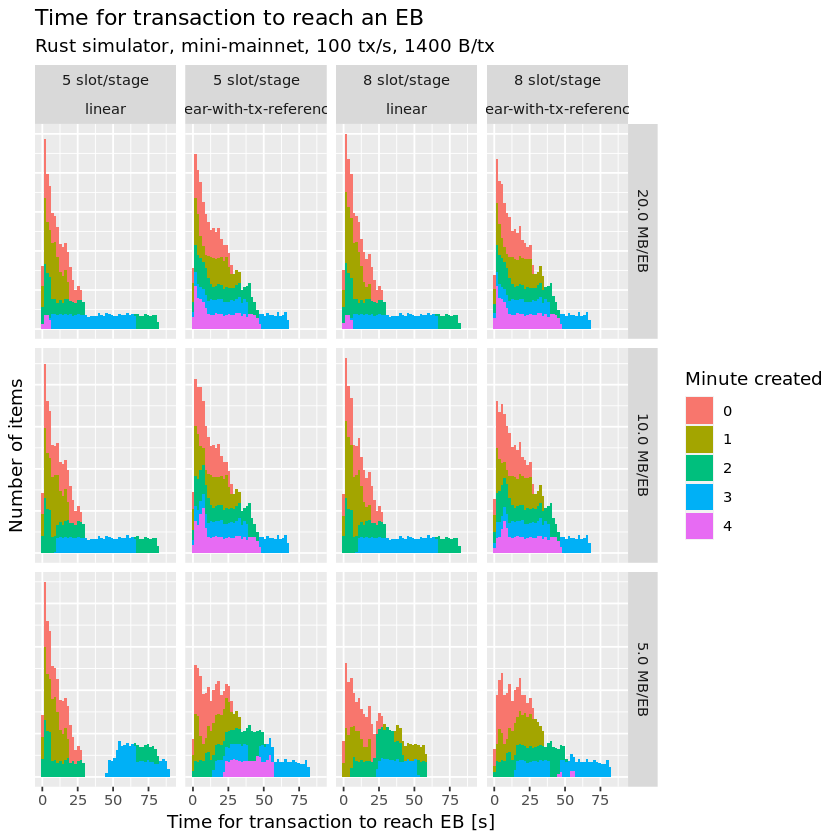

In [19]:
ggplot(
    lifecycle[
        `Kind` == "TX" & 
        !is.na(`To EB [s]`) &
        `Created [s]` >= txFirst & `Created [s]` < txLast, 
        .(`Time to reach EB [s]`=(`To EB [s]`-`Created [s]`)), 
        .(`Variant`, `Stage length`, `Max EB size`, `Minute created`=factor(floor(`Created [s]`/60)))
    ],
    aes(x=`Time to reach EB [s]`, fill=`Minute created`)
) + geom_histogram(bins=50, position="stack") +
#   scale_x_log10() +
    facet_grid(`Max EB size` ~ `Stage length` + `Variant`, scales="free_y") +
    xlab("Time for transaction to reach EB [s]") +
    ylab("Number of items") +
    ggtitle("Time for transaction to reach an EB", label) +
    theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())

In [20]:
ggsave("plots/reach-eb-tx.png", units="in", dpi=150, width=10, height=6)

#### Time to reach the ledger

In [21]:
lifecycle[
        `Kind` == "TX" & 
        !is.na(`To RB [s]`) &
        `Created [s]` >= txFirst & `Created [s]` <= txLast, 
        .(`Time to reach ledger [s]`=mean(`To RB [s]`-`Created [s]`)), 
        .(`Variant`, `Stage length`, `Max EB size`)
    ]

Variant,Stage length,Max EB size,Time to reach ledger [s]
<fct>,<fct>,<fct>,<dbl>
linear,5 slot/stage,5.0 MB/EB,58.51779
linear,5 slot/stage,10.0 MB/EB,47.19435
linear,5 slot/stage,20.0 MB/EB,47.16779
linear,8 slot/stage,5.0 MB/EB,60.55003
linear,8 slot/stage,10.0 MB/EB,62.69507
linear,8 slot/stage,20.0 MB/EB,62.72868
linear-with-tx-references,5 slot/stage,10.0 MB/EB,55.91699
linear-with-tx-references,5 slot/stage,20.0 MB/EB,55.91443
linear-with-tx-references,5 slot/stage,5.0 MB/EB,57.74856


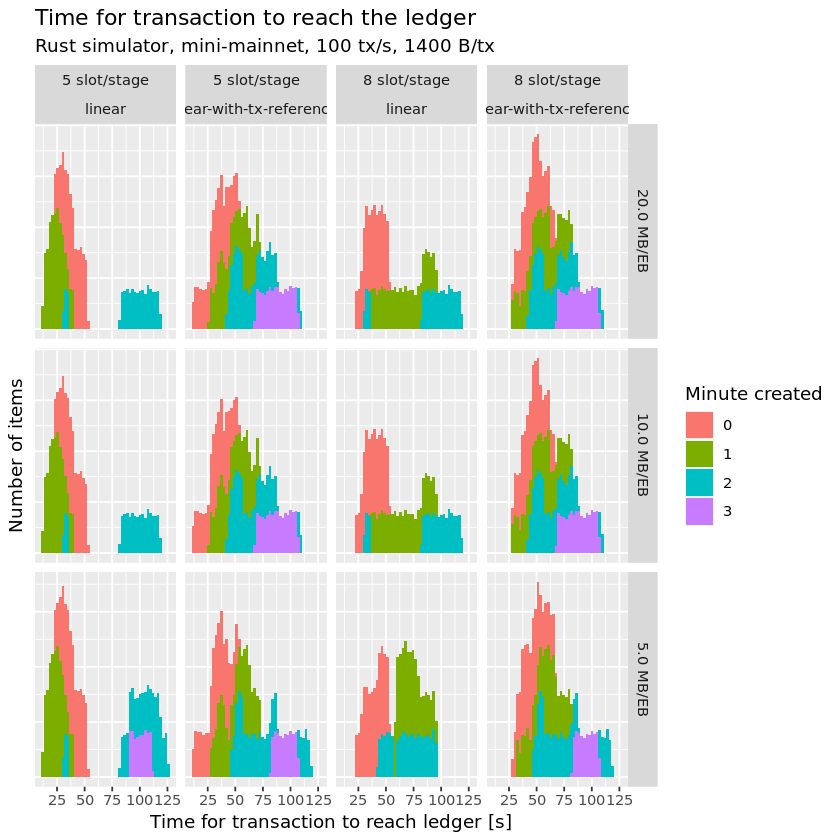

In [22]:
ggplot(
    lifecycle[
        `Kind` == "TX" & 
        !is.na(`To RB [s]`) &
        `Created [s]` >= txFirst & `Created [s]` < txLast, 
        .(`Time to reach ledger [s]`=`To RB [s]`-`Created [s]`), 
        .(`Variant`, `Kind`, `Stage length`, `Max EB size`, `Minute created`=factor(floor(`Created [s]`/60)))
    ],
    aes(x=`Time to reach ledger [s]`, fill=`Minute created`)
) + geom_histogram(bins=50) +
#   scale_x_log10() +
    facet_grid(`Max EB size` ~ `Stage length` + `Variant`, scales="free_y") +
    xlab("Time for transaction to reach ledger [s]") +
    ylab("Number of items") +
    ggtitle("Time for transaction to reach the ledger", label) +
    theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())

In [23]:
ggsave("plots/reach-rb-tx.png", units="in", dpi=150, width=8, height=6)

#### Number of references

A *reference* is one of the following:

- A transaction is included in an IB.
- An IB is referenced by an EB.
- An EB is referenced by another EB.

In an efficient Leios, the number of references for each data item would be one.

- *Zero references* indicates that the item was not used.
- *Two or more references* indicates that duplication has occurred.

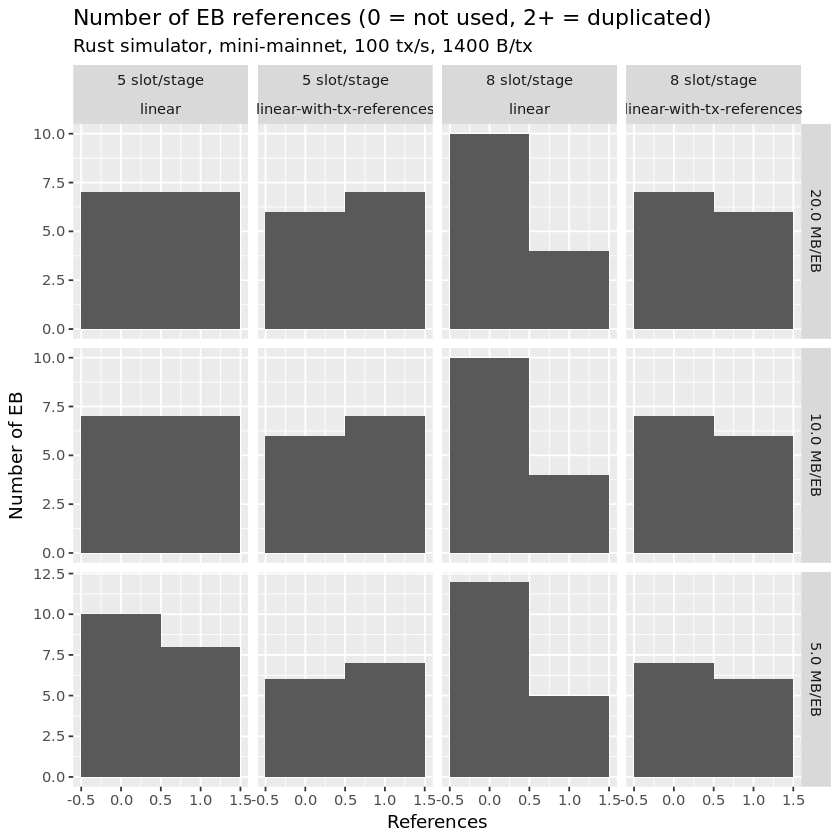

In [24]:
ggplot(
    lifecycle[
        `Kind` == "EB",
        .(`References`),
        .(`Variant`, `Stage length`, `Max EB size`)
    ], 
    aes(x=`References`)
) +
    geom_histogram(binwidth=1) +
    facet_grid(`Max EB size` ~ `Stage length` + `Variant`, scales="free_y") +
    ylab("Number of EB") +
    ggtitle("Number of EB references (0 = not used, 2+ = duplicated)", label)

In [25]:
ggsave("plots/references-tx.png", units="in", dpi=150, width=8, height=6)

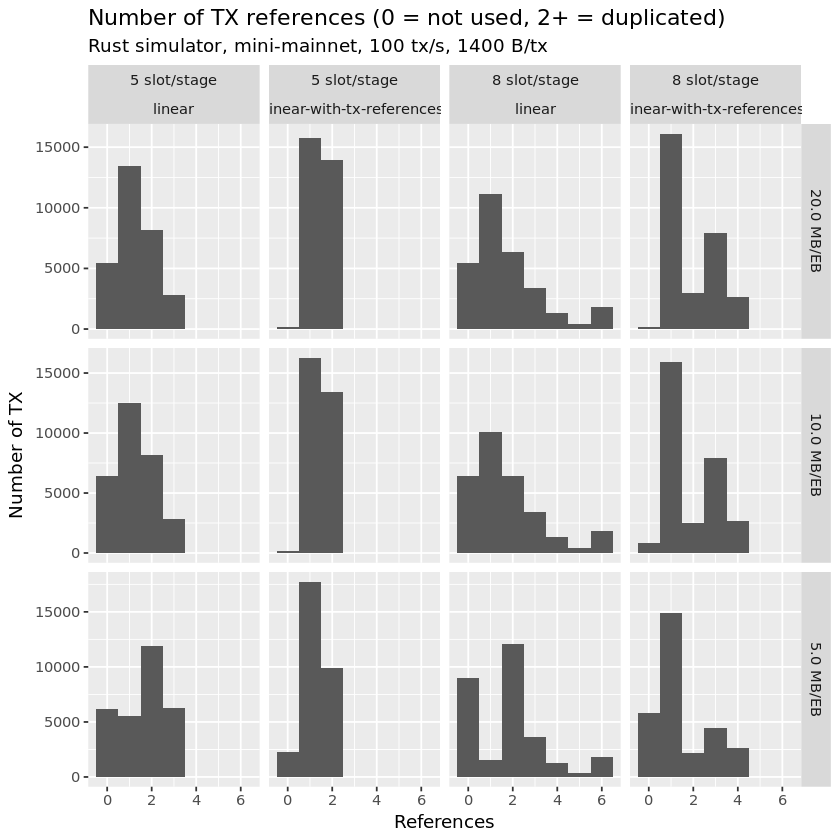

In [26]:
ggplot(
    lifecycle[
        `Kind` == "TX",
        .(`References`),
        .(`Variant`, `Stage length`, `Max EB size`)
    ], 
    aes(x=`References`)
) +
    geom_histogram(binwidth=1) +
    facet_grid(`Max EB size` ~ `Stage length` + `Variant`, scales="free_y") +
    ylab("Number of TX") +
    ggtitle("Number of TX references (0 = not used, 2+ = duplicated)", label)

In [27]:
ggsave("plots/references-tx.png", units="in", dpi=150, width=8, height=6)

#### Temporal efficiency

In [28]:
toElapsed <- function(created, toRb, inRb) {
    if (!is.na(toRb))
        toRb - created
    else if (!is.na(inRb))
        inRb - created
    else
        as.numeric(NA)
}

In [29]:
outcomes <- lifecycle[
    `Kind` == "TX",
    .(
        `Submitted [minute]`=factor(floor(`Created [s]`/60)), 
        `Time to reach ledger [s]`=mapply(toElapsed, `Created [s]`, `To RB [s]`, `In RB [s]`)
    ), .(
        `Variant`, `Stage length`, `Max EB size`
    )
][order(`Variant`, `Stage length`, `Max EB size`, `Submitted [minute]`, `Time to reach ledger [s]`)]

In [30]:
totals <- outcomes[, .(`Total`=.N, `Lost`=sum(is.na(`Time to reach ledger [s]`))), .(`Variant`, `Stage length`, `Max EB size`, `Submitted [minute]`)]

#### Transactions reaching the ledger

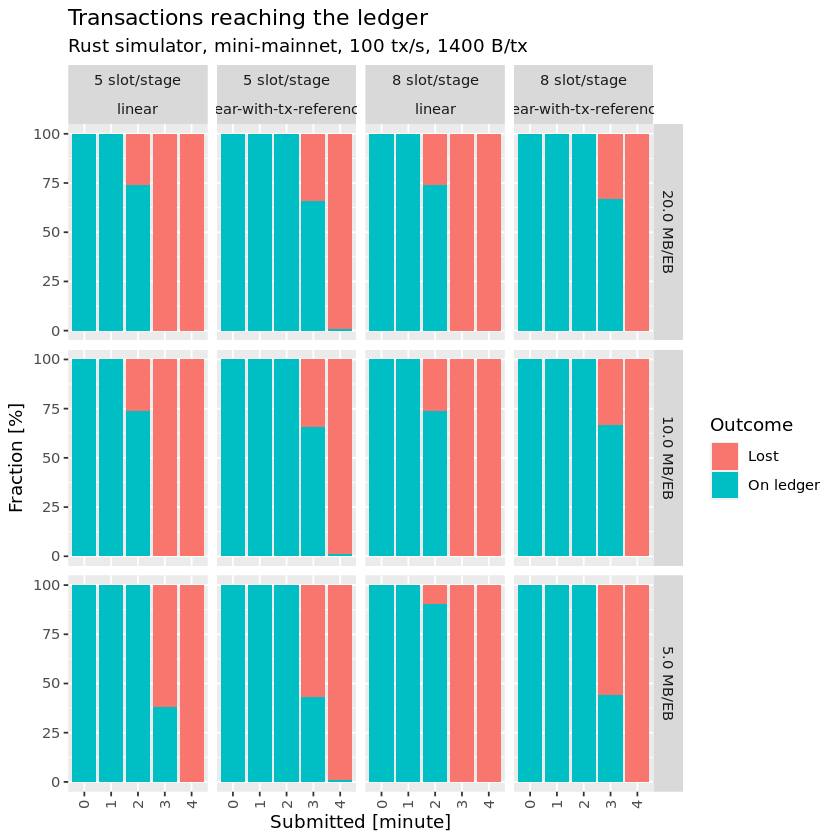

In [31]:
ggplot(
    melt(
        totals[, .(`On ledger`=1-`Lost`/`Total`, `Lost`=`Lost`/`Total`), .(`Variant`, `Stage length`, `Max EB size`, `Submitted [minute]`)],
        id.vars=c("Variant", "Stage length", "Max EB size", "Submitted [minute]"),
        variable.name="Outcome",
        value.name="Fraction"
    )[`Submitted [minute]` != 6, .(
        `Variant`,
        `Stage length`, 
        `Max EB size`,
        `Submitted [minute]`, 
        `Outcome`=factor(`Outcome`,levels=c("Lost","On ledger")), 
        `Fraction [%]`=100*`Fraction`
    )],
    aes(x=`Submitted [minute]`, y=`Fraction [%]`, fill=`Outcome`)
) +
    geom_bar(stat="identity") +
    facet_grid(`Max EB size` ~ `Stage length` + `Variant`) +
    ggtitle("Transactions reaching the ledger", label) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

In [32]:
ggsave("plots/temporal-efficiency-bar.png", units="in", dpi=150, width=8, height=6)

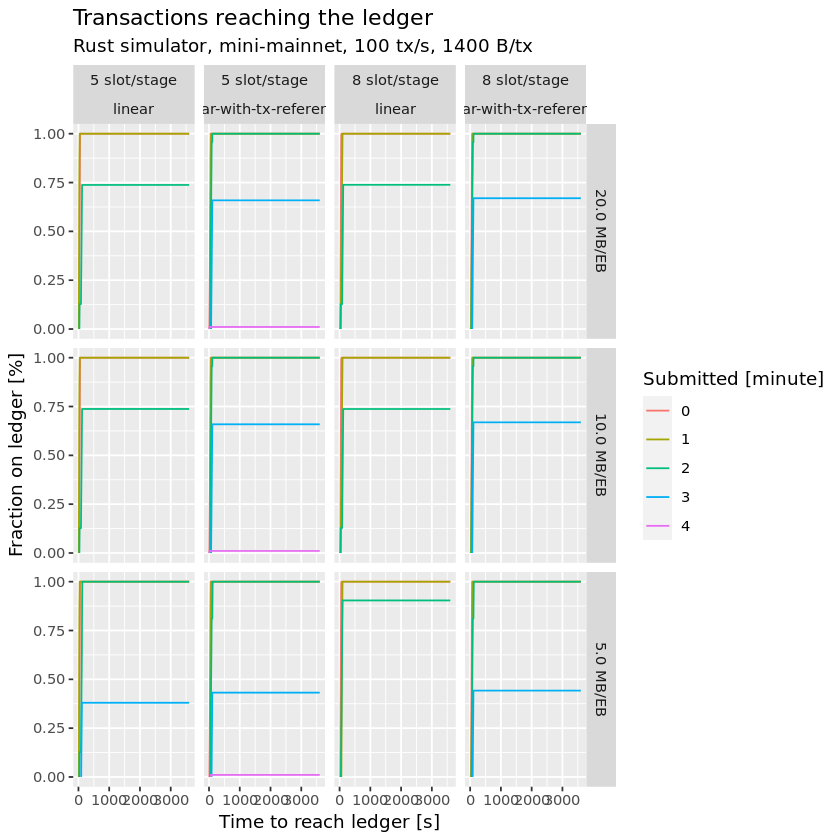

In [33]:
ggplot(
    rbind(
        totals[
            outcomes[
                !is.na(`Time to reach ledger [s]`), 
                .(`Cumulative total`=1:length(`Time to reach ledger [s]`), `Time to reach ledger [s]`), 
                .(`Variant`, `Stage length`, `Max EB size`, `Submitted [minute]`)
            ],
            on=c("Variant", "Stage length", "Max EB size", "Submitted [minute]")
        ][,
            .(`Time to reach ledger [s]`, `Fraction on ledger [%]`=`Cumulative total`/`Total`),
            .(`Variant`, `Stage length`, `Max EB size`, `Submitted [minute]`)
        ],
        totals[, .(`Fraction on ledger [%]`=1-`Lost`/`Total`, `Time to reach ledger [s]`=3600), .(`Variant`, `Stage length`, `Max EB size`, `Submitted [minute]`)]
    )[`Submitted [minute]` != 6],
    aes(x=`Time to reach ledger [s]`, y=`Fraction on ledger [%]`, color=`Submitted [minute]`)
) +
    geom_line() +
    facet_grid(`Max EB size` ~ `Stage length` + `Variant`) +
    ggtitle("Transactions reaching the ledger", label)

In [34]:
ggsave("plots/temporal-efficiency-timeseries.png", units="in", dpi=150, width=8, height=6)

#### Release memory

In [35]:
rm(lifecycle, outcomes, totals)

In [36]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1021501,54.6,1822495,97.4,1822495,97.4
Vcells,2791656,21.3,17297147,132.0,21621433,165.0


### Resource usage

In [37]:
if (file.exists("results/resources.Rdata")) {
    load(file="results/resources.Rdata")
    cat(paste("Loaded Rdata file: sampleSize =", sampleSize, "\n"))
} else {
    resources <- fread("results/resources.csv.gz", stringsAsFactors=TRUE)
    sampleSize <- 1
#   save(resources, file="results/resources.Rdata")
}
resources[, `:=`(`Max EB size`=factor(`Max EB size`, levels=c("50.0 MB/EB", "20.0 MB/EB", "10.0 MB/EB", "5.0 MB/EB", "2.0 MB/EB", "1.0 MB/EB", "0.5 MB/EB", "0.2 MB/EB")), `Stage length`=factor(`Stage length`, levels=c("5 slot/stage", "8 slot/stage", "15 slot/stage")))]
resources %>% summary

 Simulator                        Variant            Stage length 
 Rust:9000   linear                   :4500   5 slot/stage :4500  
             linear-with-tx-references:4500   8 slot/stage :4500  
                                              15 slot/stage:   0  
                                                                  
                                                                  
                                                                  
                                                                  
     Max EB size         Node        Egress [B]           Disk [B]       
 20.0 MB/EB:3000   node-0  :  12   Min.   :      630   Min.   :       0  
 10.0 MB/EB:3000   node-1  :  12   1st Qu.:  3061362   1st Qu.:       0  
 5.0 MB/EB :3000   node-10 :  12   Median : 29212315   Median :       0  
 50.0 MB/EB:   0   node-100:  12   Mean   : 43351794   Mean   :   45720  
 2.0 MB/EB :   0   node-101:  12   3rd Qu.: 58604434   3rd Qu.:       0  
 1.0 MB/EB :   0   n

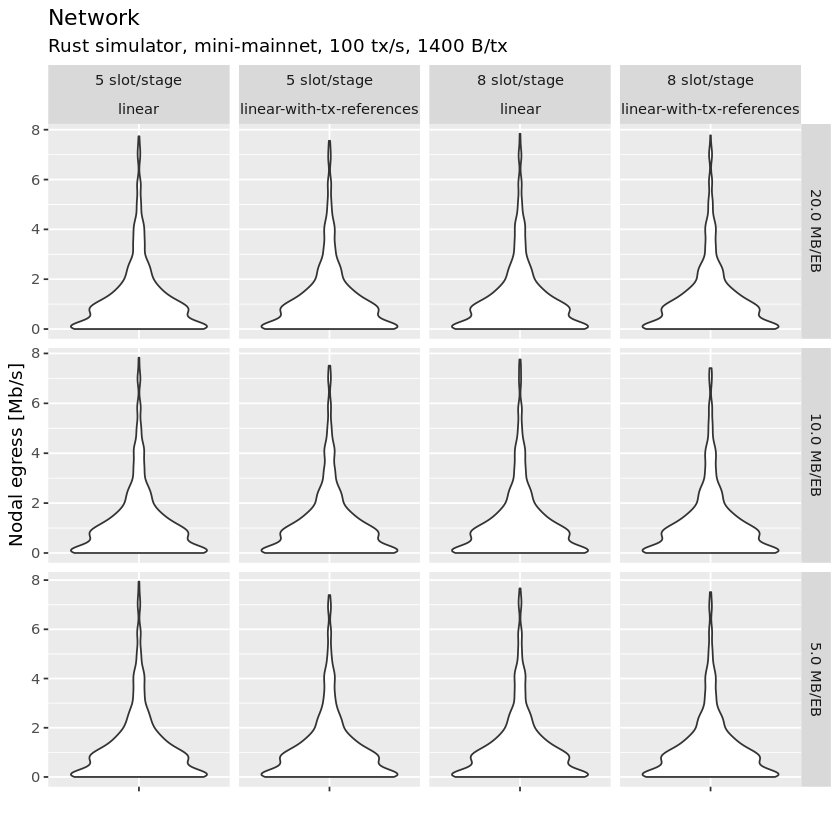

In [38]:
ggplot(
    resources[, .(`Variant`, `Stage length`, `Max EB size`, `Node`, `Nodal egress [Mb/s]`=8*`Egress [B]`/simFinish/1e6)], 
    aes(x="", y=`Nodal egress [Mb/s]`)
) +
    geom_violin() +
    facet_grid(`Max EB size` ~ `Stage length` + `Variant`, scales="free_y") +
    xlab("") +
    ggtitle("Network", label)

In [39]:
ggsave("plots/network.png", units="in", dpi=150, width=9.5, height=5.5)

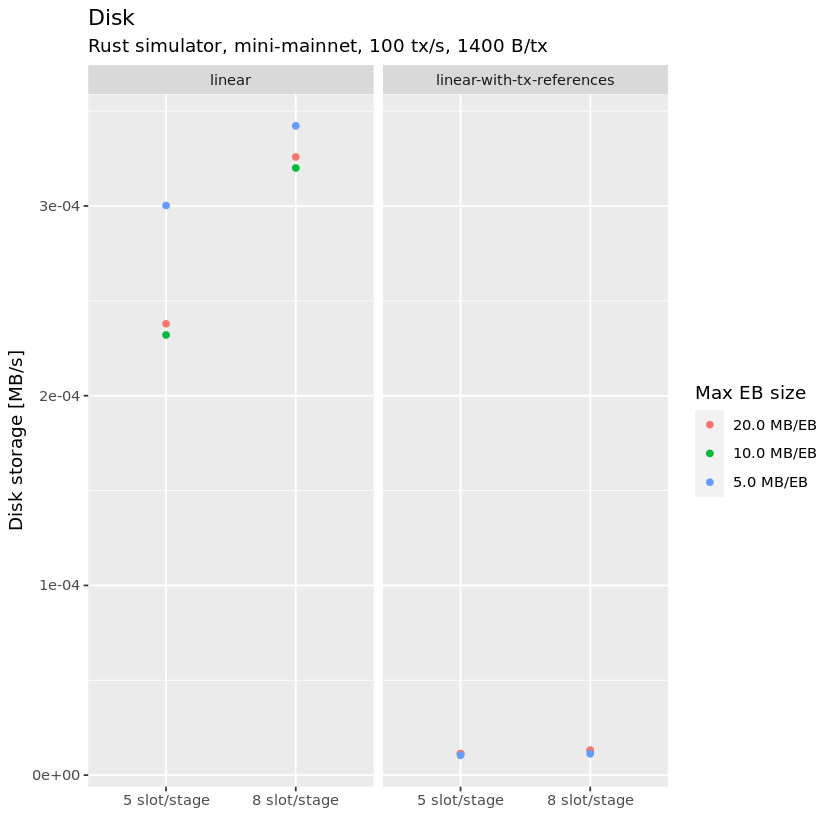

In [40]:
ggplot(
    resources[, .(`Disk storage [MB/s]`=mean(`Disk [B]`)/simFinish/1e6), .(`Variant`, `Stage length`, `Max EB size`)],
    aes(x=`Stage length`, color=`Max EB size`, y=`Disk storage [MB/s]`)
) +
    geom_point() +
    xlab("") +
    facet_grid(. ~ `Variant`) +
    ggtitle("Disk", label)

In [41]:
ggsave("plots/disk.png", units="in", dpi=150, width=9.5, height=5.5)

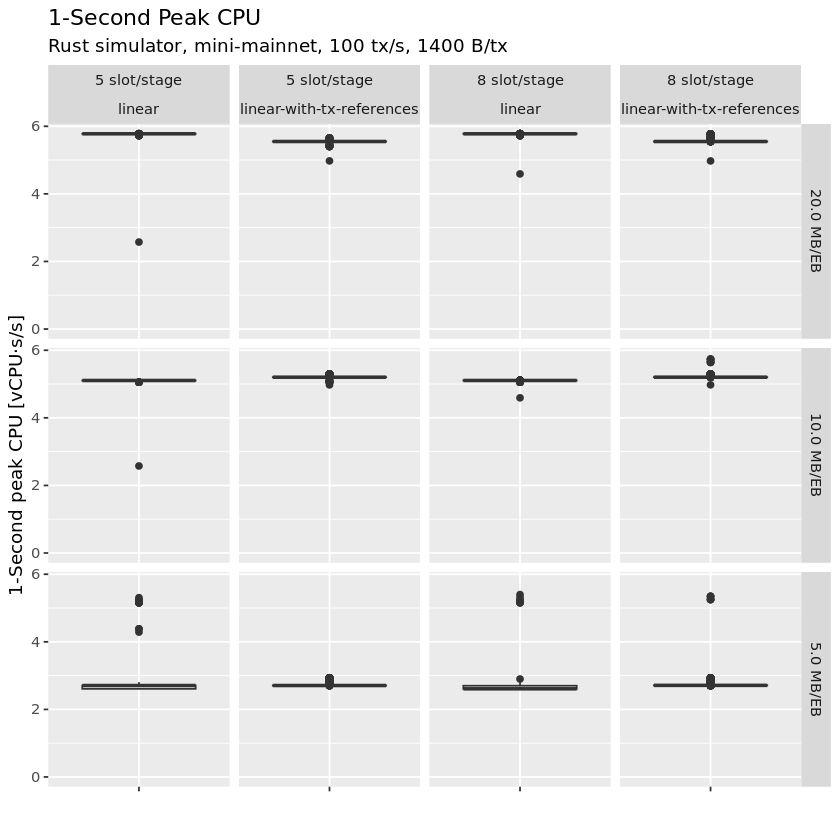

In [42]:
ggplot(
    resources[, .(`Node`, `Variant`, `Stage length`, `Max EB size`, `1-Second peak CPU [vCPU⋅s/s]`=`Maximum CPU [s/s]`)], 
    aes(x="", y=`1-Second peak CPU [vCPU⋅s/s]`)
) +
    geom_boxplot() +
    ylim(0, NA) +
    facet_grid(`Max EB size` ~ `Stage length` + `Variant`) +
    xlab("") +
    ggtitle("1-Second Peak CPU", label)

In [43]:
ggsave("plots/cpu-peak.png", units="in", dpi=150, width=9.5, height=5.5)

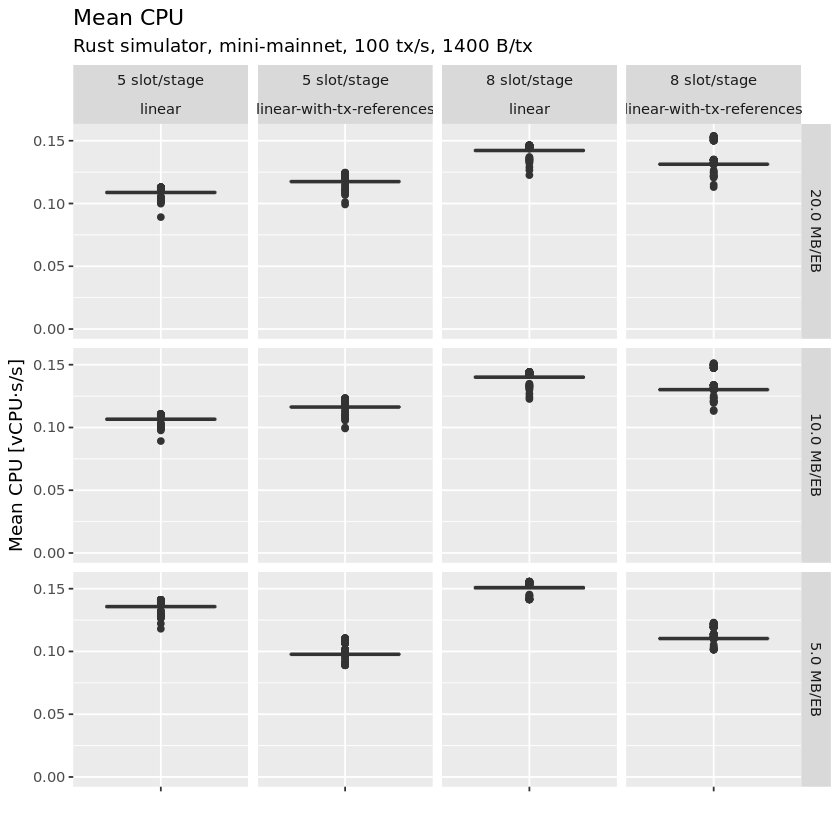

In [44]:
ggplot(
    resources[, .(`Variant`, `Stage length`, `Max EB size`, `Node`, `Mean CPU [vCPU⋅s/s]`=`Total CPU [s]`/simFinish
        )
    ], aes(x="", y=`Mean CPU [vCPU⋅s/s]`)
) +
    geom_boxplot() +
    ylim(0, NA) +
    facet_grid(`Max EB size` ~ `Stage length` + `Variant`) +
    xlab("") +
    ggtitle("Mean CPU", label)

In [45]:
ggsave("plots/cpu-mean.png", units="in", dpi=150, width=9.5, height=5.5)

#### Release memory

In [46]:
rm(resources)

In [47]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1052072,56.2,1822495,97.4,1822495,97.4
Vcells,1937934,14.8,11070175,84.5,21621433,165.0


### Receipt of messages

#### Read results

In [48]:
if (file.exists("results/receipts.Rdata")) {
    load("results/receipts.Rdata")
    cat(paste("Loaded Rdata file: sampleSize =", sampleSize, "\n"))
} else {
    receipts <- fread("results/receipts.csv.gz", stringsAsFactors=TRUE)
    sampleSize <- 1
#   save(receipts, file="results/receipts.Rdata")
}
receipts[, `:=`(`Max EB size`=factor(`Max EB size`, levels=c("50.0 MB/EB", "20.0 MB/EB", "10.0 MB/EB", "5.0 MB/EB", "2.0 MB/EB", "1.0 MB/EB", "0.5 MB/EB", "0.2 MB/EB")), `Stage length`=factor(`Stage length`, levels=c("5 slot/stage", "8 slot/stage", "15 slot/stage")))]
receipts %>% summary

 Simulator                             Variant         
 Rust:288617131   linear                   :144947603  
                  linear-with-tx-references:143669528  
                                                       
                                                       
                                                       
                                                       
                                                       
        Stage length           Max EB size       Kind          
 5 slot/stage :144441306   5.0 MB/EB :96814227   EB:   122599  
 8 slot/stage :144175825   10.0 MB/EB:95907842   RB:   133979  
 15 slot/stage:        0   20.0 MB/EB:95895062   TX:268438004  
                           50.0 MB/EB:       0   VT: 19922549  
                           2.0 MB/EB :       0                 
                           1.0 MB/EB :       0                 
                           (Other)   :       0                 
           Item               Producer  

In [49]:
kinds <- receipts[, unique(`Kind`) %>% sort]
kinds

[1] EB RB TX VT
Levels: EB RB TX VT

#### Arrival histograms

##### Compare the distributions of elapsed times

In [50]:
arrivalDelayHistogram <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[, .(`Variant`, `Stage length`, `Max EB size`, `Elapsed [s]`, `Minute created`=factor(floor(`Generated [s]`/60)))],
        aes(x=`Elapsed [s]`, fill=`Minute created`)
    ) +
        geom_histogram(binwidth=0.1) +
        facet_grid(`Max EB size` ~ `Stage length` + `Variant`, scales=scales) +
#       coord_cartesian(xlim=c(0, 3)) +
        xlab("Time from generation to receipt at node [s]") +
        ylab("Number received") +
        ggtitle(title, subtitle=label) +
        theme(axis.text.y = element_blank(), axis.ticks.y = element_blank())
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

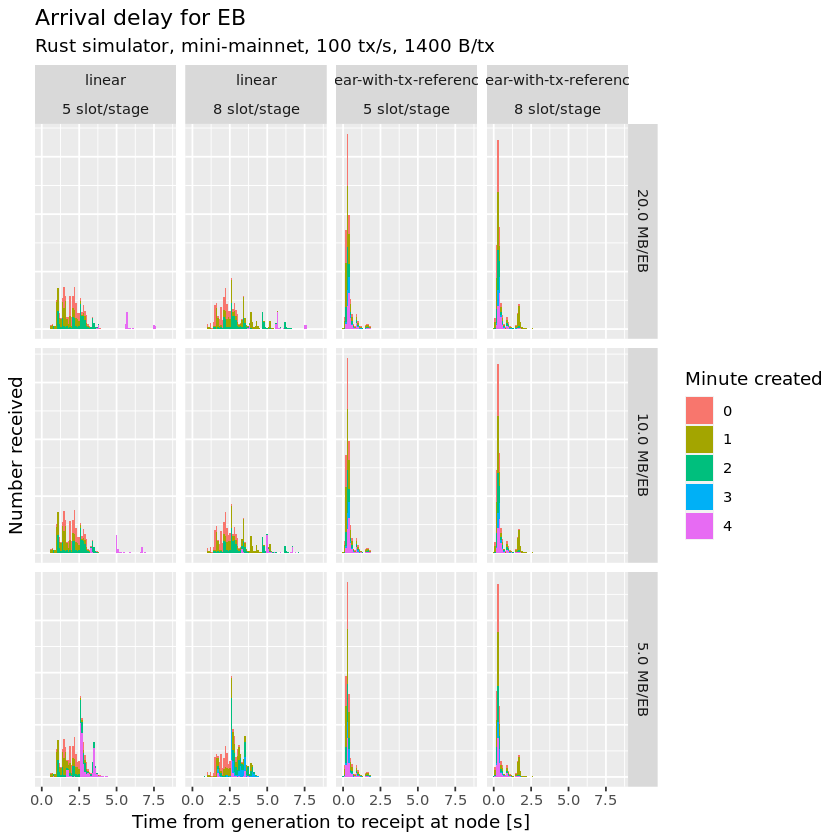

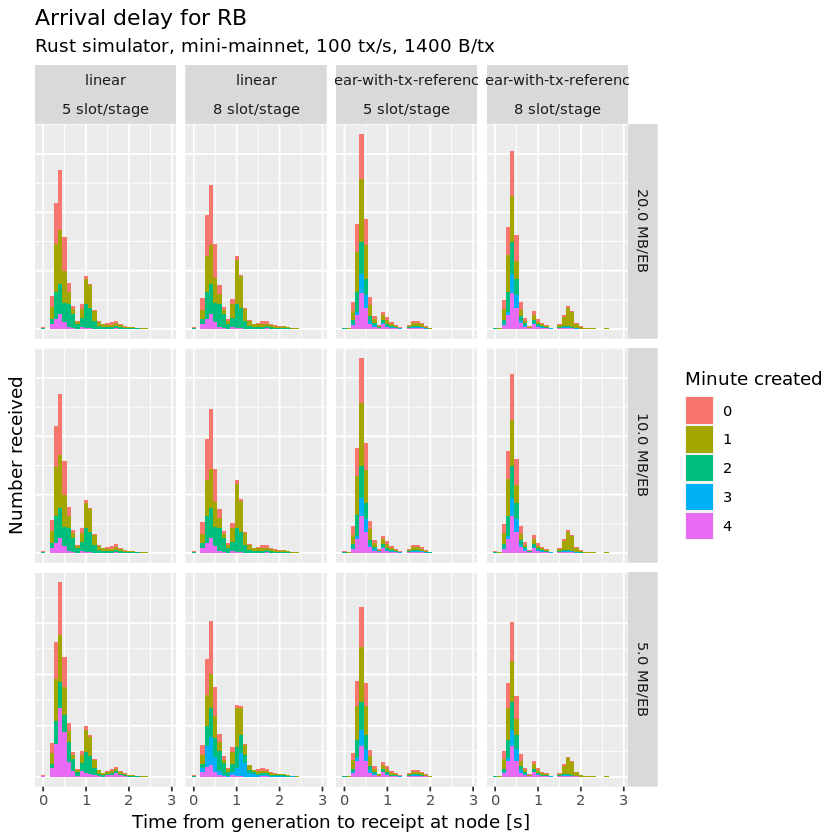

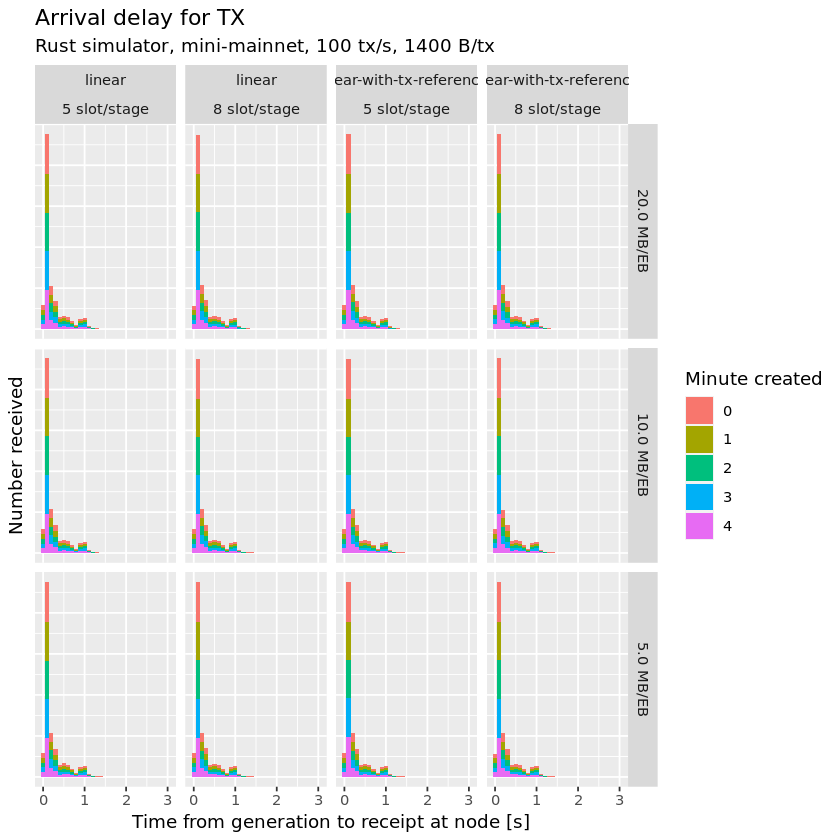

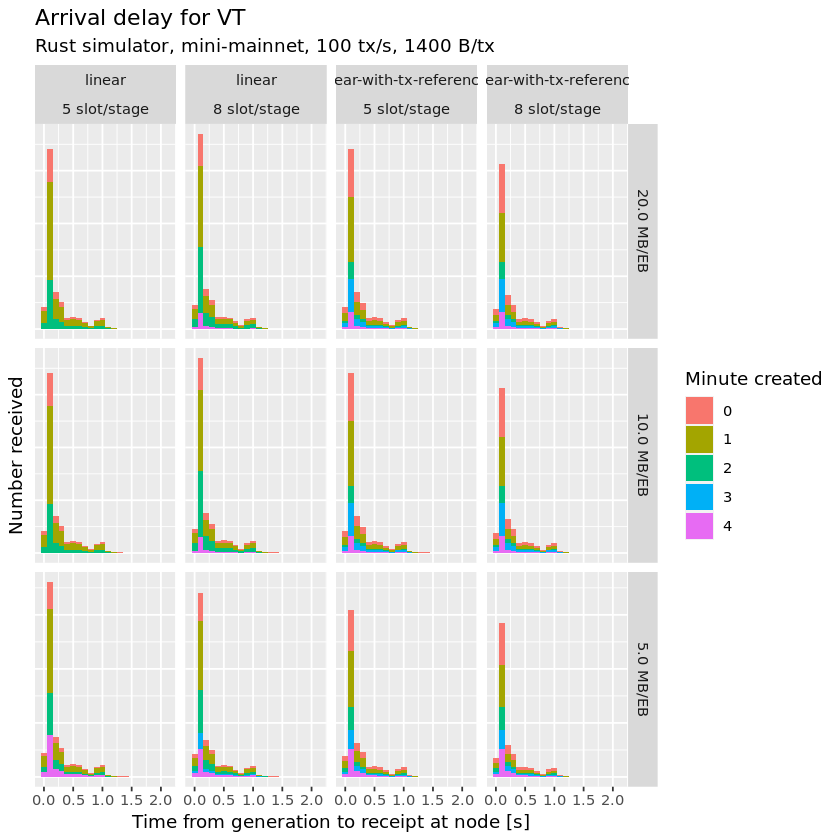

In [51]:
for (k in kinds)
    arrivalDelayHistogram(
        receipts[`Kind` == k],
        paste("Arrival delay for", k),
        scales="free_y",
        outfiles=paste0("plots/elapsed-", k, ".png")
    ) %>% print

#### Bandwidth usage

##### Total network bandwidth

In [52]:
totalBandwidthPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(`Size [Gb]`=8*sum(`Size [B]`, rm.na=TRUE)/1e9/sampleSize),
            by=.(`Variant`, `Stage length`, `Max EB size`, `Slot`=floor(`Received [s]`), `Message`=`Kind`)
        ],
        aes(x=`Slot`, y=`Size [Gb]`, fill=`Message`)
    ) +
        geom_area() +
        facet_grid(`Max EB size` ~ `Stage length` + `Variant`, scales=scales) +
#       scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Total network ingress [Gb/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

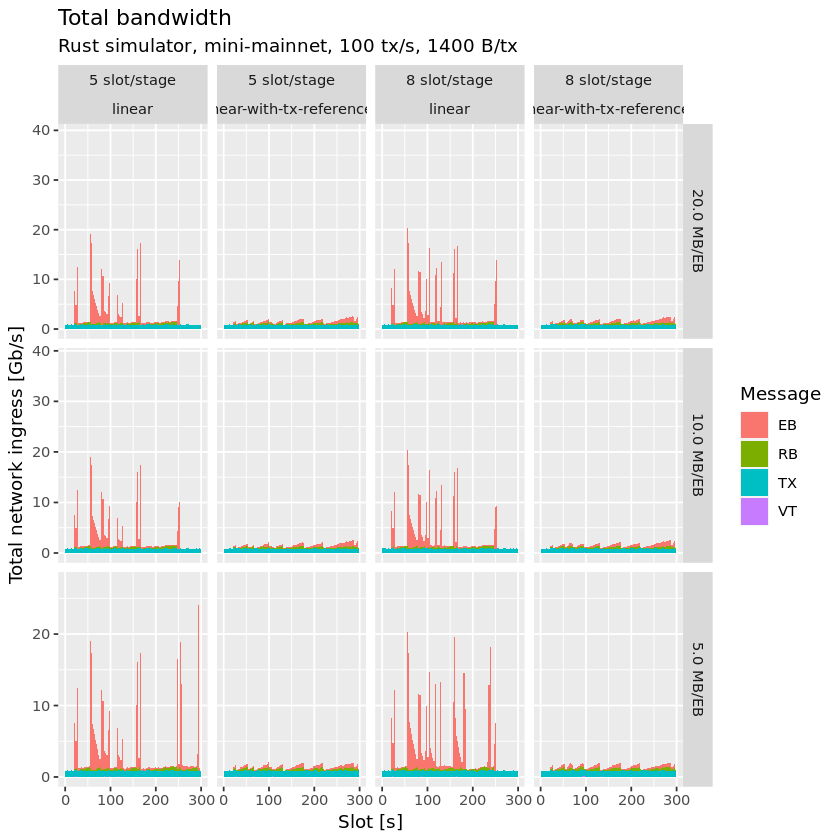

In [53]:
totalBandwidthPlot(
    receipts,
    "Total bandwidth",
    scales="free_y",
    outfiles=paste0("plots/ingress-total-area.png")
)

##### Bandwidth usage per node

In [54]:
nodeCount <- receipts[, length(unique(`Recipient`))]
nodeCount

[1] 750

In [55]:
meanNodalIngressPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(`Size [Mb/node]`=8*sum(`Size [B]`)/1e6 /nodeCount/sampleSize),
            by=.(`Variant`, `Stage length`, `Max EB size`, `Slot`=floor(`Received [s]`), `Message`=`Kind`)
        ],
        aes(x=`Slot`, y=`Size [Mb/node]`, fill=`Message`)
    ) +
        geom_area() +
        facet_grid(`Max EB size` ~ `Stage length` + `Variant`, scales=scales) +
#       scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Mean network ingress among nodes [Mb/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

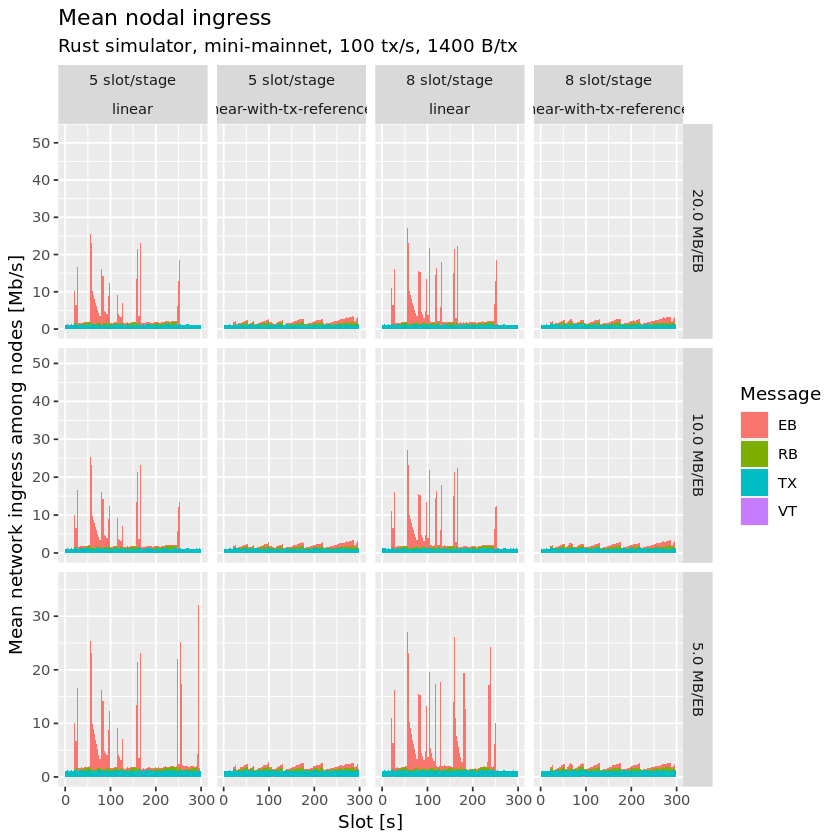

In [56]:
meanNodalIngressPlot(
    receipts, 
    "Mean nodal ingress",
    scales="free_y",
    outfiles=paste0("plots/ingress-average-area.png")
)

In [57]:
peakNodalIngressPlot <- function(rs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        rs[,
            .(`Size [Mb]`=8*sum(`Size [B]`, rm.na=TRUE)/1e6/sampleSize),
            by=.(`Variant`, `Stage length`, `Max EB size`, `Slot`=floor(`Received [s]`), `Message`=`Kind`, `Recipient`)
        ][,
            .(`Size [Mb]`=max(`Size [Mb]`)),
            by=.(`Variant`, `Stage length`, `Max EB size`, `Slot`, `Message`)
        ],
        aes(x=`Slot`, y=`Size [Mb]`, color=`Message`)
    ) +
        geom_point(size=0.5) +
        facet_grid(`Max EB size` ~ `Stage length` + `Variant`, scales=scales) +
#       scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Maximum network ingress among nodes [Mb/s]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

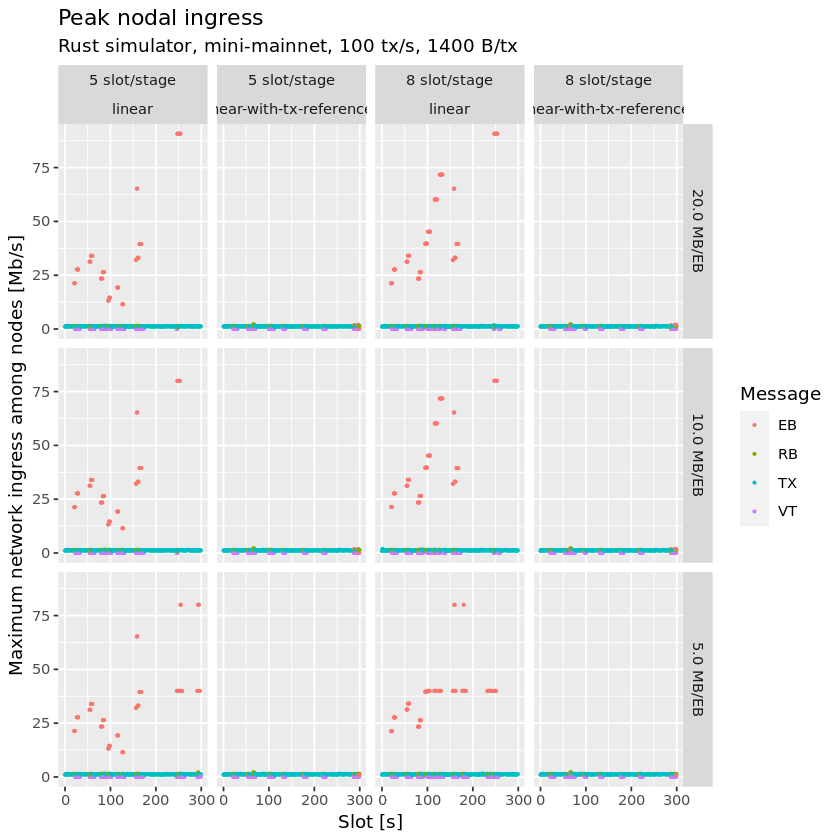

In [58]:
peakNodalIngressPlot(
    receipts, 
    "Peak nodal ingress",
    outfiles=paste0("plots/ingress-peak-point.png")
)

#### Release memory

In [59]:
rm(receipts)

In [60]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1099053,58.7,2226994,119.0,2226994,119.0
Vcells,2537630566,19360.6,7293768746,55647.1,11396513665,86948.5


### CPU usage

#### Read results

In [61]:
if (file.exists("results/cpus.Rdata")) {
    load(file="results/cpus.Rdata")
    cat(paste("Loaded Rdata file: sampleSize =", sampleSize, "\n"))
} else {
    cpus <- fread("results/cpus.csv.gz", stringsAsFactors=TRUE)
    sampleSize <- 1
#   save(cpus, file="results/cpus.Rdata")
}
cpus[, `:=`(`Max EB size`=factor(`Max EB size`, levels=c("50.0 MB/EB", "20.0 MB/EB", "10.0 MB/EB", "5.0 MB/EB", "2.0 MB/EB", "1.0 MB/EB", "0.5 MB/EB", "0.2 MB/EB")), `Stage length`=factor(`Stage length`, levels=c("5 slot/stage", "8 slot/stage", "15 slot/stage")))]
cpus %>% summary

 Simulator                             Variant         
 Rust:288892813   linear                   :145098175  
                  linear-with-tx-references:143794638  
                                                       
                                                       
                                                       
                                                       
                                                       
        Stage length           Max EB size            Slot      
 5 slot/stage :144580105   5.0 MB/EB :96913899   Min.   :  0.0  
 8 slot/stage :144312708   10.0 MB/EB:95995857   1st Qu.: 72.0  
 15 slot/stage:        0   20.0 MB/EB:95983057   Median :145.0  
                           50.0 MB/EB:       0   Mean   :147.4  
                           2.0 MB/EB :       0   3rd Qu.:222.0  
                           1.0 MB/EB :       0   Max.   :300.0  
                           (Other)   :       0                  
       Node                Task 

In [66]:
cpusNode <-
cpus[
    ,
    .(`Duration [s]`=sum(`Duration [s]`)),
    by=.(`Variant`, `Stage length`, `Max EB size`, `Node`, `Slot`)
]

In [67]:
nodeCount <- cpusNode[, length(unique(`Node`))]
nodeCount

[1] 750

#### Peak CPU usage

##### Histogram

In [68]:
peakCpuHistogram <- function(cs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(`Duration [%]`=100*max(`Duration [s]`)),
            by=.(`Variant`, `Stage length`, `Max EB size`, `Slot`)
        ], 
        aes(x=`Duration [%]`)
    ) +
        geom_histogram(binwidth=10) +
        facet_grid(`Max EB size` ~ `Stage length` + `Variant`, scales=scales) +
      # coord_cartesian(xlim=c(0, 700)) +
        xlab("Peak CPU load [%]") +
        ylab("Number of slots") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

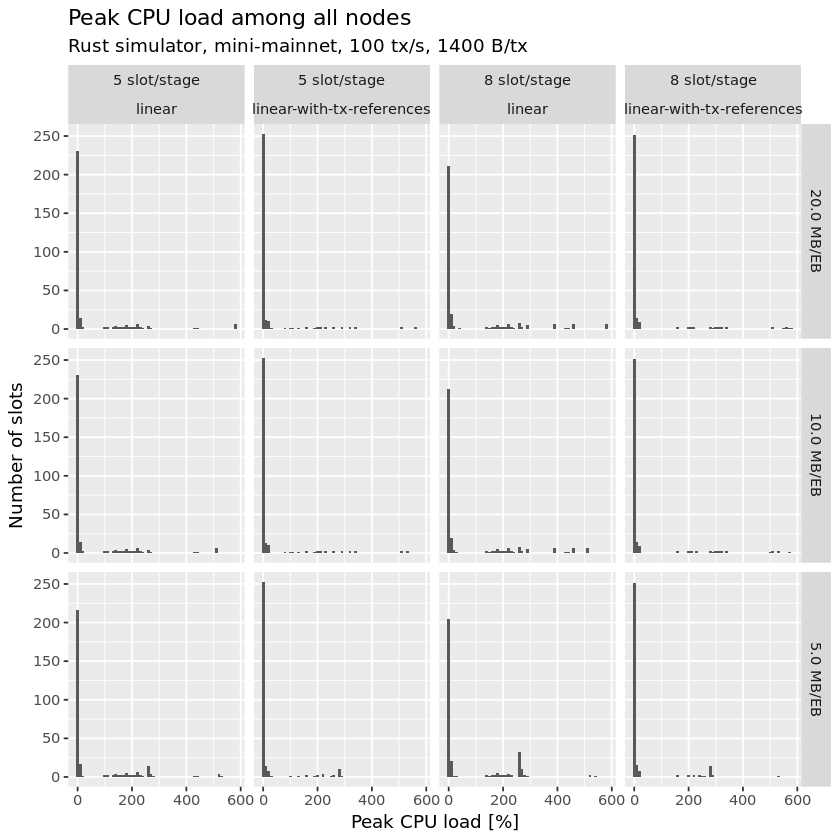

In [69]:
peakCpuHistogram(
    cpusNode, 
    "Peak CPU load among all nodes",
    scales="free_y",
    outfiles=paste0("plots/cpu-peak-histogram.png")
)

##### Time series

In [70]:
peakCpuTimeseries <- function(cs, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(`Duration [%]`=100*mean(`Duration [s]`)/sampleSize),
            by=.(`Variant`, `Stage length`, `Max EB size`, `Slot`)
        ], 
        aes(x=`Slot`, y=`Duration [%]`)) +
        geom_line() +
        facet_grid(`Max EB size` ~ `Stage length` + `Variant`, scale=scales) +
#       scale_y_sqrt() +
        xlab("Slot") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

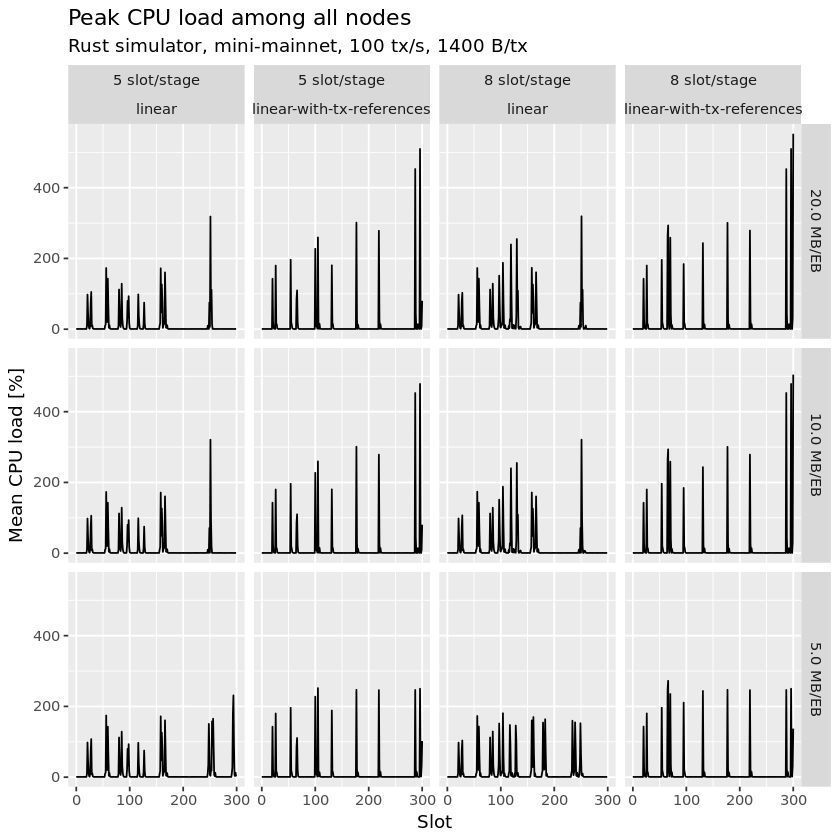

In [71]:
peakCpuTimeseries(
    cpusNode,
    "Peak CPU load among all nodes",
    outfiles=paste0("plots/cpu-peak-timeseries.png")
)

#### Mean CPU usage

##### Histogram

In [72]:
meanCpuHistogram <- function(cs, nodeSeconds, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(`Duration [%]`=100*sum(`Duration [s]`)/nodeSeconds),
            by=.(`Variant`, `Stage length`, `Max EB size`, `Task`)
        ], 
        aes(x="", fill=`Task`, y=`Duration [%]`)) +
        geom_bar(stat = "identity") +
        facet_grid(`Max EB size` ~ `Stage length` + `Variant`, scales=scales) +
        xlab("") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

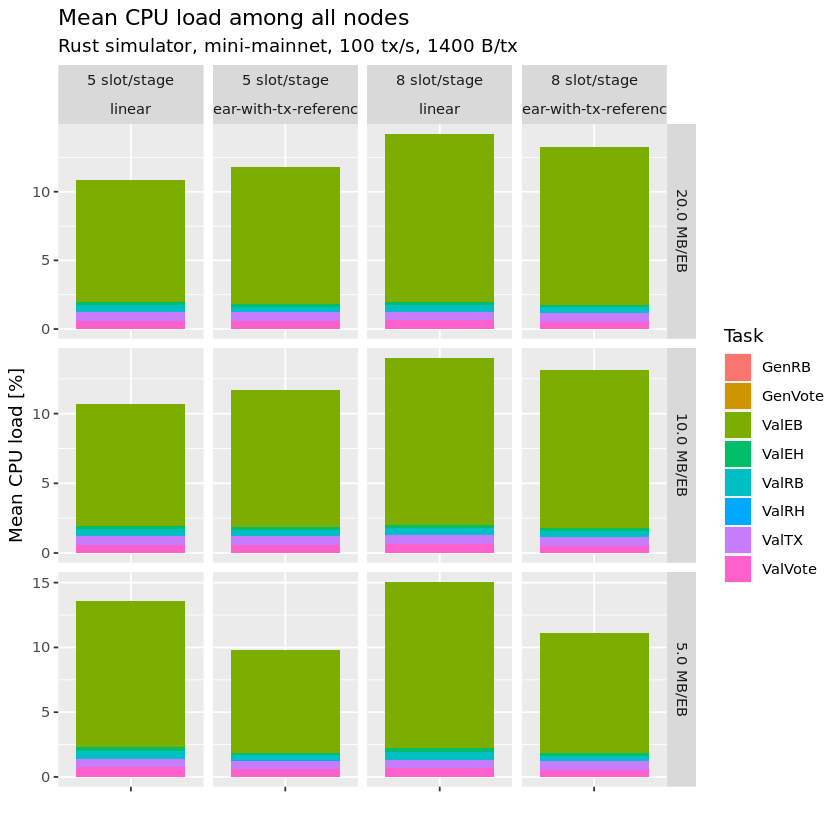

In [73]:
meanCpuHistogram(
    cpus[`Slot` >= txFirst & `Slot` < txLast],
    nodeCount * txWindow * sampleSize, 
    "Mean CPU load among all nodes", 
    scales="free_y",
    outfiles=paste0("plots/cpu-mean-histogram.png")
)

##### Time series

In [74]:
meanCpuTimeseries <- function(cs, nodeSeconds, title="", scales="fixed", outfiles=c(), width=8, height=6, dpi=150) {
    g <- ggplot(
        cs[,
            .(`Duration [%]`=100*sum(`Duration [s]`)/nodeSeconds),
            by=.(`Variant`, `Stage length`, `Max EB size`, `Slot`, `Task`)
        ], 
        aes(x=`Slot`, y=`Duration [%]`, color=`Task`)
    ) +
        geom_point(size=0.25, alpha=0.75) +
        facet_grid(`Max EB size` ~ `Stage length` + `Variant`, scales=scales) +
        scale_y_sqrt() +
        xlab("Slot") +
        ylab("Mean CPU load [%]") +
        ggtitle(title, subtitle=label)
    for (outfile in outfiles)
        ggsave(outfile, units="in", width=width, height=height, dpi=dpi)
    g
}

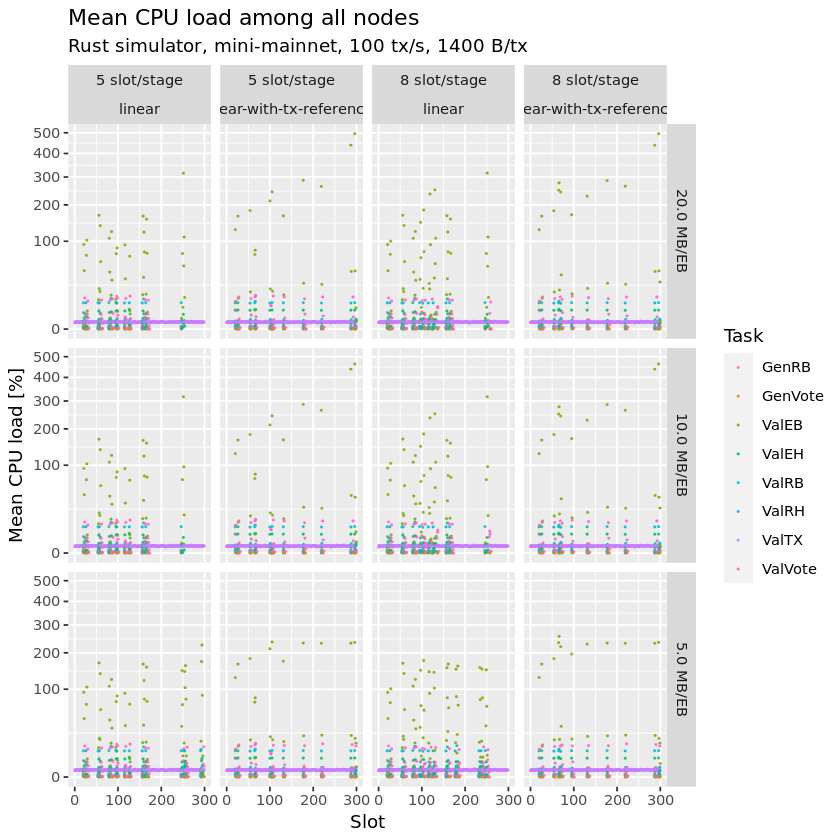

In [75]:
meanCpuTimeseries(
    cpus, 
    nodeCount * sampleSize, 
    "Mean CPU load among all nodes",
    outfiles=paste0("plots/cpu-mean-timeseries.png")
)

#### Release memory

In [76]:
rm(cpus, cpusNode)

In [77]:
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1068513,57.1,2226994,119.0,2226994,119.0
Vcells,1406962787,10734.3,5835014997,44517.7,11396513665,86948.5
